In [1]:
### The code written here obtains the global Fisher information 
### using new set of ODEs, compares with that obtained from JAX
### ODE solver and the analytic solution.

In [2]:
import jax
from jax import config
import jax.numpy as jnp

### Restricting the usage to the CPU
jax.config.update('jax_default_device', jax.devices('cpu')[0])

# # JAX supports single-precisions numbers by default.For double precision, use:
# # https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
config.update("jax_enable_x64", True)

## 2. Square pulse plot:

Text(0.5, 0, '$t$')

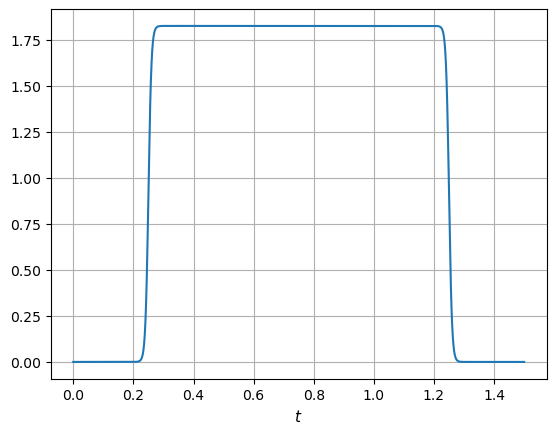

In [3]:
import matplotlib.pyplot as plt
from functions_square import square_pulse, pulse_norm

avg_num_phot=3.3 ### average photon number of the pulse
twidth = 1.0 ### final time 
######################################################
### Plot:
tarr = jnp.linspace(0, 1.5*twidth,2000)
norm_value = pulse_norm(twidth, avg_num_phot)
plt.plot(tarr, square_pulse(tarr, twidth, avg_num_phot, norm_value))
plt.grid(True)
plt.xlabel(r"$t$", size=11)

## 3. QFI computed using ODEs and two-sided master equation:

In [4]:
from functions_square import (qfi_odes_contribs, qfi_odes, 
                              qfi_twosided, qfi_analytic, fpval_analytic)

### Parameters:
avg_num_phot = 3.37
###########################################################################
### Width values: different values suggested for different alpha2##########

# twidth = jnp.linspace(0.001*jnp.sqrt(12),10.0*jnp.sqrt(12),500) #alpha2=0.01
twidth = jnp.linspace(0.001*jnp.sqrt(12),15.0*jnp.sqrt(12),1000) #alpha2=1
# twidth = jnp.linspace(0.001*jnp.sqrt(12), 60.0*jnp.sqrt(12),500) #alpha2=10
# twidth = jnp.linspace(0.001*jnp.sqrt(12),160.0*jnp.sqrt(12),500) #alpha2=10^2
# twidth = jnp.linspace(0.001*jnp.sqrt(12),900.0*jnp.sqrt(12),1000) #alpha2=10^4
###########################################################################
###########################################################################

### 1. Evaluating QFI using the two-sided Master equation:
QFI_two_sided_vec =jax.vmap(qfi_twosided,
                            in_axes=(0,None,None))
two_sided_soln=QFI_two_sided_vec(twidth, avg_num_phot, 0.0)

######################################################################
### 2. Evaluating QFI using the ODEs derived in the paper for different
###  values of tcap using JAX
QFI_cont_vec = jax.vmap(qfi_odes_contribs, in_axes=(0,None))
ODE_soln_cont = QFI_cont_vec(twidth, avg_num_phot)

QFI_ODEs_vec = jax.vmap(qfi_odes, in_axes=(0,None))
ODE_soln = QFI_ODEs_vec(twidth, avg_num_phot)
#######################################################################
### 3. Evaluating QFI analytics:
Gamma=1.0
tfinal_vec = twidth + (10/Gamma)*jnp.log(10)

QFI_analytic_vec = jax.vmap(qfi_analytic, in_axes=(0, 0, None))
ans = QFI_analytic_vec(tfinal_vec, twidth, jnp.sqrt(avg_num_phot))

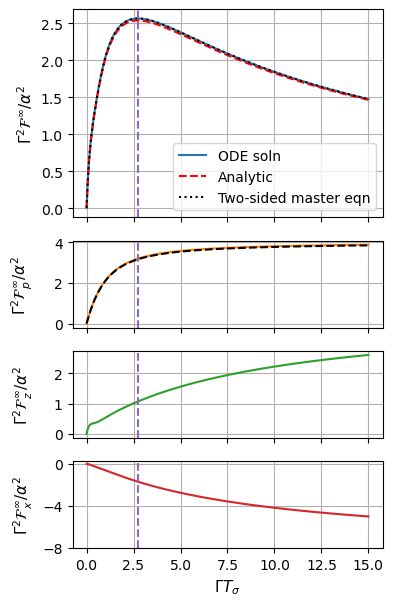

var_opt: 2.7335505505505506
twidth_opt: 9.46929687722286
QFI_opt: 2.562070847966318


In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#############################################################################
#### Creating a plot:#######################################################
fig = plt.figure(figsize=(4.0, 7.0))
gs  = gridspec.GridSpec(nrows=4, ncols=1, figure=fig,
    height_ratios=[3.0, 1.25, 1.25, 1.25], hspace=0.2, wspace=0.48)

axes = []
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
############################################################################
#############################################################################
### Plotting:
ax1.plot(twidth/jnp.sqrt(12), ODE_soln, label='ODE soln')
ax1.plot(twidth/jnp.sqrt(12), ans, ls = '--', color='red', label='Analytic')
ax1.plot(twidth/jnp.sqrt(12), two_sided_soln, ls = ':', color='black', label='Two-sided master eqn')

ax1.axvline(x=twidth[jnp.argmax(ODE_soln)]/jnp.sqrt(12), ls='--', color='tab:purple')
ax1.set_ylabel(r"$\Gamma^{2} \mathcal{F}^{\infty}/\alpha^{2}$", size=11)
ax1.set_xlabel(r"$\Gamma T_{\sigma}$", size=11)
ax1.tick_params(axis='both', labelsize=10)  # Set tick label font size to 10
ax1.legend(loc='lower right', ncol=1, fontsize=10)
ax1.grid(True)

ax2.plot(twidth/jnp.sqrt(12), ODE_soln_cont[0], color='tab:orange')
ax2.plot(twidth/jnp.sqrt(12), fpval_analytic(twidth), ls='--', color='black', label='Analytic')
ax2.axvline(x=twidth[jnp.argmax(ODE_soln)]/jnp.sqrt(12), ls='--', color='tab:purple')
ax2.set_ylabel(r"$\Gamma^{2}\mathcal{F}_{p}^{\infty}/\alpha^{2}$", size=11)
ax2.tick_params(axis='both', labelsize=10)  # Set tick label font size to 1
ax2.grid(True)

ax3.plot(twidth/jnp.sqrt(12), ODE_soln_cont[1], color='tab:green')
ax3.axvline(x=twidth[jnp.argmax(ODE_soln)]/jnp.sqrt(12), ls='--', color='tab:purple')
ax3.set_ylabel(r"$\Gamma^{2}\mathcal{F}_{z}^{\infty}/\alpha^{2}$", size=11)
ax3.tick_params(axis='both', labelsize=10)  # Set tick label font size to 10
ax3.tick_params(axis='both', labelsize=10)  # Set tick label font size to 10
ax3.grid(True)

ax4.plot(twidth/jnp.sqrt(12), ODE_soln_cont[2], color='tab:red')
ax4.axvline(x=twidth[jnp.argmax(ODE_soln)]/jnp.sqrt(12), ls='--', color='tab:purple')
ax4.tick_params(axis='both', labelsize=10)  # Set tick label font size to 10
ax4.set_ylabel(r"$\Gamma^{2}\mathcal{F}_{x}^{\infty}/\alpha^{2}$", size=11)
ax4.set_xlabel(r"$\Gamma T_{\sigma}$", size=11)
ax4.set_yticks([0,-4,-8])
ax4.grid(True)
#########################################################################
# Hide x-axis tick labels for all but the last (bottom) subplot
for ax in [ax1, ax2, ax3]:
    ax.label_outer()

axes.extend([ax1, ax2, ax3, ax4])
fig.align_ylabels(axes) #aligning all the y-axis labels
plt.show()
#########################################################################
print("var_opt:",twidth[jnp.argmax(ODE_soln)]/jnp.sqrt(12))
print("twidth_opt:",twidth[jnp.argmax(ODE_soln)])
print("QFI_opt:", jnp.max(ODE_soln))

## 5: Optimization over the width of the pulse:

In [6]:
from functions_square import sing_inst_qfi_optimizer

avg_num_phot = 3.37
ini_seed = 1.0
(opt_twidth, opt_qfi, opt_success) =  sing_inst_qfi_optimizer(ini_seed, avg_num_phot)

print("optimal width:",opt_twidth)
print("optimal QFI:",opt_qfi)
print("Success of the optimizer:",opt_success)

optimal width: 9.480238799713481
optimal QFI: 2.5620715891281165
Success of the optimizer: 1.0


## 6. Optimization as a function of average photon number:

In [7]:
import numpy as np
import concurrent.futures as cf
from functions_square import sing_inst_qfi_optimizer

#######################################################
### Range of average photon number:
start=-2.0 #min avg_phot_num = 10.0**-2
end=4.0 #max avg_phot_num = 10.0**4
avg_num_phot_vec =np.logspace(start, end, 100, endpoint=True)

#######################################################
### Storing the optimizer output:
opt_twidth_vals = np.zeros(len(avg_num_phot_vec)) #optimal tcap values
opt_qfi_vals = np.zeros(len(avg_num_phot_vec)) #optimal QFI
opt_success_vals = np.zeros(len(avg_num_phot_vec)) #success of optimizer

#######################################################
### Running optimization in parallel:
### Define the number of threads (cores) you want to use
num_threads = 3

### Note that this is convex optimization, so one random
### seed suffices
ini_seed = 1.0 #randomly chosen value
with cf.ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Submit the tasks to the executor:
    futures = {executor.submit(sing_inst_qfi_optimizer, ini_seed,
                avg_num_phot_vec[ind1]): ind1
               for ind1 in range(len(avg_num_phot_vec))}
    
    # Wait for all futures to complete and store results in width_vals:
    dummy=0
    for future in cf.as_completed(futures):
        print(dummy, end='\r')
        dummy+=1
        ind1 = futures[future]  # Get the index of the result from the dictionary
        (opt_twidth_vals[ind1], opt_qfi_vals[ind1], opt_success_vals[ind1]) = future.result()  # Store the result

### prints true if every optimization is successful:
print(jnp.all(opt_success_vals == 1))


True


## 7. Plotting the optimizer values:

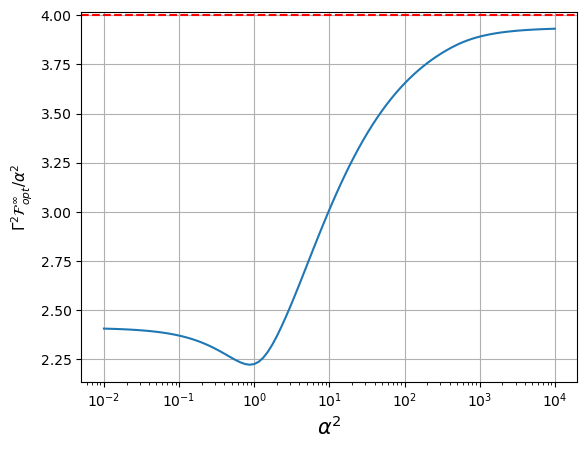

In [8]:
import matplotlib.pyplot as plt
plt.semilogx(avg_num_phot_vec, opt_qfi_vals,'-')
plt.xlabel(r"$\alpha^{2}$",size='15')
plt.ylabel(r"$\Gamma^{2} \mathcal{F}^{\infty}_{opt}/\alpha^{2}$", size=11)
plt.axhline(y=4.0, ls = '--', color='red')
plt.grid()

# Saving data:

In [ ]:
# import numpy as np
# np.savez(f"QFI_square_{avg_num_phot}avg_phot",
#          tsigma= tcap/jnp.sqrt(12), F1=ODE_soln_cont[0],
#          F2=ODE_soln_cont[1], F3=ODE_soln_cont[2])

# np.savez(f"fisher_optimization_square_-2.0_4.0avgphotons_logspace",
#          avg_num_phot= avg_num_phot_vec, qfi_vals=opt_qfi_vals)